# Reconocimiento de celebridades con Amazon Rekognition

Este notebook ofrece un walkthrough por la API de reconocimiento de celebridades en Amazon Rekognition. Puede identificar rápidamente a personas conocidas en nuestras bibliotecas de videos e imágenes para catalogar secuencias y fotos para casos de uso en la industria del marketing, la publicidad y los medios de comunicación.

    https://docs.aws.amazon.com/rekognition/latest/dg/celebrities.html
    https://docs.aws.amazon.com/rekognition/latest/dg/API_RecognizeCelebrities.html
    https://docs.aws.amazon.com/rekognition/latest/dg/API_StartCelebrityRecognition.html
    https://docs.aws.amazon.com/rekognition/latest/dg/API_GetCelebrityRecognition.html

## Check setup

In [2]:
%store -r setup_dependencies_passed

In [3]:
try:
    setup_dependencies_passed
except NameError:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN THE PREVIOUS NOTEBOOK ")
    print("You did not install the required libraries.   ")
    print("++++++++++++++++++++++++++++++++++++++++++++++")

In [4]:


print(setup_dependencies_passed)



True


In [5]:
if not setup_dependencies_passed:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN THE PREVIOUS NOTEBOOK ")
    print("You did not install the required libraries.   ")
    print("++++++++++++++++++++++++++++++++++++++++++++++")
else:
    print("[OK]")

[OK]


## Setup notebook

In [8]:
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

import sagemaker
import boto3

In [11]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name
rekognition = boto3.client("rekognition")
s3 = boto3.client("s3")

## Obtenemos la imagen y la subimos a S3

In [12]:
!mkdir -p ./tmp
!curl -s -o ./tmp/gerard-pique.png "https://www.lecturas.com/medio/2022/11/06/gerard-pique-llorando_611ca467_1280x720.jpg"

In [13]:
temp_folder = "tmp/"
image_name = "gerard-pique.png"

In [14]:
s3.upload_file(
    f"./tmp/{image_name}",
    bucket,
    image_name
)

In [15]:
display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": image_name})))

## Llamar a Amazon Rekognition para reconocer a los famosos en la imagen

https://docs.aws.amazon.com/rekognition/latest/dg/API_RecognizeCelebrities.html

In [16]:
recognizeCelebritiesResponse = rekognition.recognize_celebrities(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": image_name,
        }
    }
)

In [17]:
def drawBoundingBoxes(sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255, 255, 255), (255, 255, 255), (76, 182, 252), (52, 194, 123))

    # Download image locally
    imageLocation = temp_folder + os.path.basename(sourceImage)
    s3.download_file(bucket, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line = 3
    for box in boxes:
        x1 = int(box[1]["Left"] * width)
        y1 = int(box[1]["Top"] * height)
        x2 = int(box[1]["Left"] * width + box[1]["Width"] * width)
        y2 = int(box[1]["Top"] * height + box[1]["Height"] * height)

        draw.text((x1, y1), box[0], colors[col])
        for l in range(line):
            draw.rectangle((x1 - l, y1 - l, x2 + l, y2 + l), outline=colors[col])
        col = (col + 1) % maxcol

    imageFormat = "PNG"
    ext = sourceImage.lower()
    if ext.endswith("jpg") or ext.endswith("jpeg"):
        imageFormat = "JPEG"

    bbImage.save(imageLocation, format=imageFormat)

    display(bbImage)

## Revisar la respuesta JSON devuelta por la API de reconocimiento de celebridades de Rekognition

In [18]:
display(recognizeCelebritiesResponse)

{'CelebrityFaces': [{'Urls': ['www.wikidata.org/wiki/Q17507'],
   'Name': 'Gerard Piqué',
   'Id': '1py6Wv5',
   'Face': {'BoundingBox': {'Width': 0.20871062576770782,
     'Height': 0.4933435320854187,
     'Left': 0.3783603310585022,
     'Top': 0.18256013095378876},
    'Confidence': 99.99929809570312,
    'Landmarks': [{'Type': 'eyeRight',
      'X': 0.5273646116256714,
      'Y': 0.3683370351791382},
     {'Type': 'mouthLeft', 'X': 0.4367571473121643, 'Y': 0.5316901803016663},
     {'Type': 'mouthRight', 'X': 0.5133451223373413, 'Y': 0.5440810322761536},
     {'Type': 'nose', 'X': 0.4734054207801819, 'Y': 0.46078312397003174},
     {'Type': 'eyeLeft', 'X': 0.43582209944725037, 'Y': 0.3538985252380371}],
    'Pose': {'Roll': 5.118805885314941,
     'Yaw': -3.4563307762145996,
     'Pitch': -2.3590645790100098},
    'Quality': {'Brightness': 75.29692077636719,
     'Sharpness': 73.32209777832031},
    'Emotions': [{'Type': 'SAD', 'Confidence': 98.69453430175781},
     {'Type': 'CONF

## Mostrar imagen con cuadros delimitadores alrededor de las celebridades reconocidas

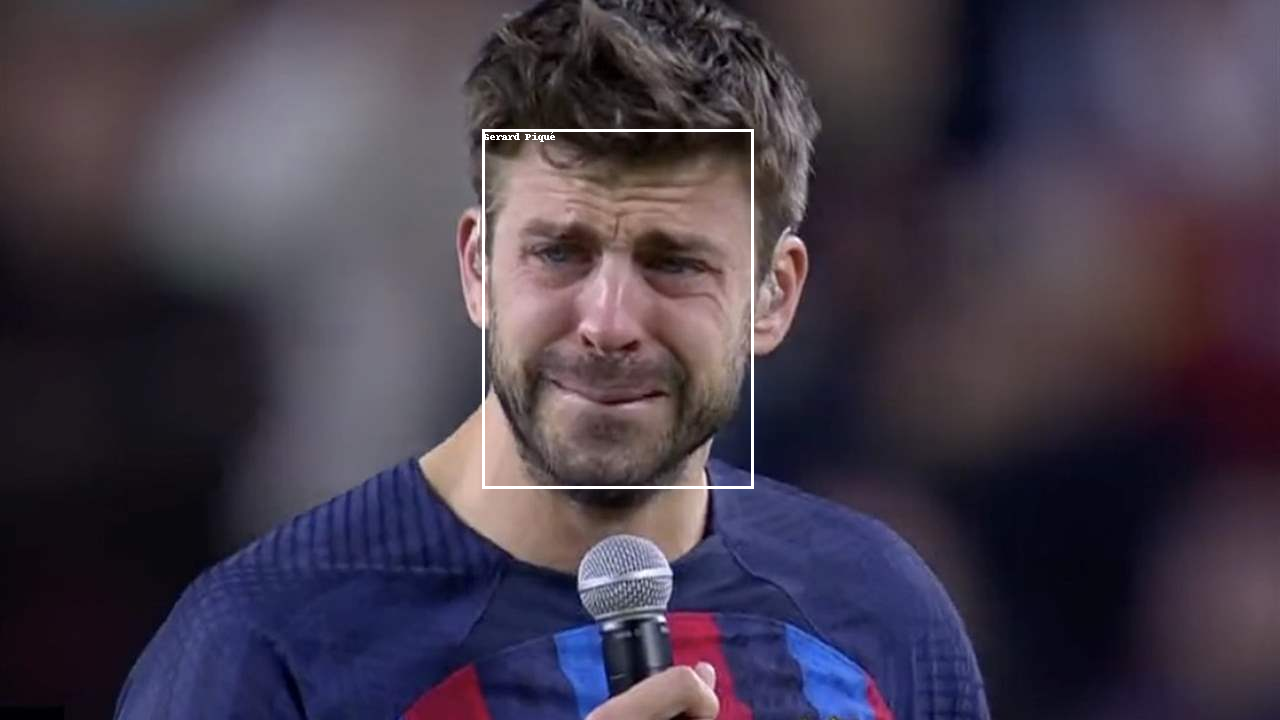

In [19]:
boxes = []
celebrities = recognizeCelebritiesResponse["CelebrityFaces"]
for celebrity in celebrities:
    boxes.append((celebrity["Name"], celebrity["Face"]["BoundingBox"]))

drawBoundingBoxes(image_name, boxes)

## Liberar recursos

In [20]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

In [21]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.b>p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernelbutton>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
script>
